In [158]:
import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
import scipy.io

from tqdm import tqdm
import pandas as pd

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

In [104]:
data = scipy.io.loadmat('PowerValuesOctMay.mat')
data = data['MeasurementsTotal']
data = np.squeeze(data)

In [154]:
# create dataframe with the data
date_rng = pd.date_range(start='2014-10-05', end='2015-06-01', freq='H', closed='left')
df = pd.DataFrame(date_rng, columns=['date'])
df['consumption'] = data
df.head(5)

,date,consumption
0,2014-10-05 00:00:00,129.336728
1,2014-10-05 01:00:00,134.729526
2,2014-10-05 02:00:00,130.954735
3,2014-10-05 03:00:00,128.923580
4,2014-10-05 04:00:00,127.021535


In [156]:
# create features

# day
df['day'] = df['date'].map(lambda date: date.dayofweek)

# hour
df['hour'] = df['date'].map(lambda date: date.hour)

# holidays
christmas_holidays = pd.date_range(start='2014-12-18', end='2015-01-04', freq='H')
easter_holidays = pd.date_range(start='2015-03-25', end='2015-04-03', freq='H')
holidays = christmas_holidays.union(easter_holidays)
df['holiday'] = df['date'].map(lambda date: 1 if date in holidays else 0)

df.head()

,date,consumption,day,hour,holiday
0,2014-10-05 00:00:00,129.336728,6,0,0
1,2014-10-05 01:00:00,134.729526,6,1,0
2,2014-10-05 02:00:00,130.954735,6,2,0
3,2014-10-05 03:00:00,128.923580,6,3,0
4,2014-10-05 04:00:00,127.021535,6,4,0


In [157]:
# do one-hot encoding on all categorical features

df = pd.get_dummies(data=df, prefix=['day'], columns=['day'])
df = pd.get_dummies(data=df, prefix=['hour'], columns=['hour'])
df.head()

,date,consumption,holiday,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2014-10-05 00:00:00,129.336728,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2014-10-05 01:00:00,134.729526,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2014-10-05 02:00:00,130.954735,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2014-10-05 03:00:00,128.923580,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2014-10-05 04:00:00,127.021535,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [196]:
# Linear regression

scaler = MinMaxScaler(feature_range=(0,1))
y = df[['consumption']].as_matrix()
y_log = scaler.fit_transform(y)

X_train = df.iloc[:-574,-32:].as_matrix()
X_test = df.iloc[-574:,-32:].as_matrix()
y_train = y[:-574]
y_test = y[-574:]
y_log_train = y_log[:-574]
y_log_test = y_log[-574:]

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg_log = linear_model.LinearRegression()
reg_log.fit(X_train, y_log_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
y_log_pred_train = scaler.inverse_transform(reg_log.predict(X_train))
y_log_pred_test = scaler.inverse_transform(reg_log.predict(X_test))

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


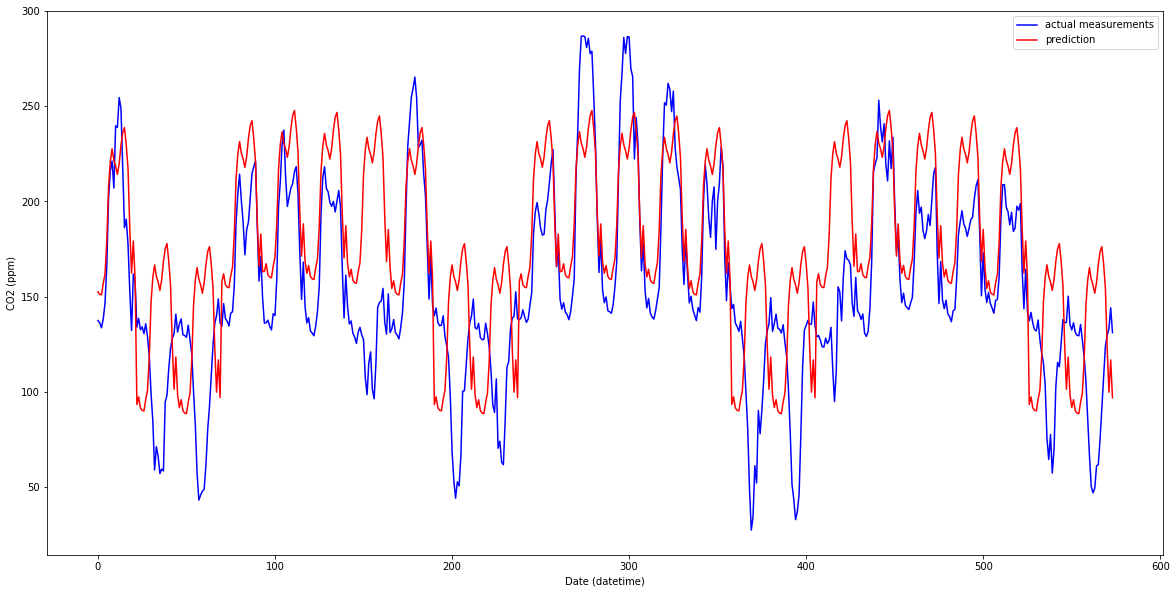

In [198]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_test, label = 'actual measurements', color='blue')
ax.plot(y_log_pred_test, label = 'prediction', color='red')
plt.legend()
plt.ylabel('CO2 (ppm)')
plt.xlabel('Date (datetime)')
plt.show()

In [199]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test)

2223.9325092690087

In [201]:
mean_squared_error(y_test, y_log_pred_test)

2226.9614337621165

In [202]:
mean_squared_error(y_train, y_pred_train)

1210.131706720257

In [203]:
mean_squared_error(y_train, y_log_pred_train)

1209.9746347382506